# Handwritten Digit Recognition with Projected Quantum Kernels

In this notebook, images of handwritten digits are classified by a quantum computer. Quantum machine learning methods promise advantages over conventional algorithms because they can map data into an exponentially large state space. However, the size of the space can also have disadvantages. In this notebook, the data is projected back into a classical space after being mapped into the Hilbert space, in order to take advantage of the benefits of QML without its drawbacks.

This notebook will make use of sQUlearn's implementations of Quantum Support Vector Classification [squlearn.kernel.QSVC](https://sQUlearn.github.io/...) and Projected Quantum Kernels [squlearn.kernel.ProjectedQuantumKernel](https://sQUlearn.github.io/...).

The dataset used here is well known from conventional machine learning and easily solvable with conventional methods. The workflow that that is applied to solve the classification with a quantum computer is representative for this kind of task and can be transfered to more complex datasets.

<center>
<img src="images/pipeline.png" alt="pipeline" width="800"/>

*Fig. 1: Pipeline used in this notebook.*
</center>

Let's start off by doing some imports and defining helper functions.

### Imports and Definitions

In [1]:
import matplotlib.pylab as plt
from matplotlib.lines import Line2D
import numpy as np

from sklearn.datasets import load_digits
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from squlearn import Executor
from squlearn.feature_map import ChebPQC
from squlearn.kernel.ml.qsvc import QSVC
from squlearn.kernel.matrix import ProjectedQuantumKernel

The definitions of the helper functions are hidden for sake of readability. If you want to replicate this code, please see the definitions of the helper functions at [the original notebook](https://github.com/sQUlearn/squlearn/blob/main/examples/tutorials/kernel_classification_mnist.ipynb)

In [2]:
def plot_data_in_feature_space(X, y, highlight_rows):
    X_m = np.ma.array(X, mask=False)
    X_m.mask[highlight_rows] = True

    y_m = np.ma.array(y, mask=False)
    y_m.mask[highlight_rows] = True

    fig, ax = plt.subplots(figsize=(12, 8))
    s1 = ax.scatter(X_m[:, 0], X_m[:, 1], c=y_m, cmap=plt.cm.tab10, marker="o", s=10)
    s2 = ax.scatter(
        X[highlight_rows, 0],
        X[highlight_rows, 1],
        c=y[highlight_rows],
        cmap=plt.cm.tab10,
        marker="X",
        s=80,
        edgecolors="k",
        vmin=0,
        vmax=9,
    )
    ax.legend(
        [
            Line2D(
                [0],
                [0],
                color="w",
                marker="X",
                markerfacecolor="w",
                markeredgecolor="k",
                markersize=10,
            ),
            Line2D(
                [0],
                [0],
                color="w",
                marker="o",
                markerfacecolor="w",
                markeredgecolor="k",
                markersize=6,
            ),
        ],
        ["Samples", "Dataset"],
        loc="lower right",
    )
    cbar = fig.colorbar(s2, ticks=(0.5 + np.arange(10)) * 10 / 11)
    cbar.ax.set_yticklabels(np.arange(10, dtype=int))
    cbar.ax.tick_params(size=0, labelsize="large")


def plot_dataset(X, y, rows=5):
    indices = np.stack(
        [
            np.random.choice(np.argwhere(y == i).ravel(), size=rows, replace=False)
            for i in range(10)
        ]
    )
    fig, axs = plt.subplots(rows, 11)
    for i in range(rows):
        axs[i][0].axis("off")
        axs[i][0].set_aspect("equal")
        for j in range(10):
            axs[i][j + 1].imshow(X[indices[j, i], :].reshape(8, 8), cmap="Greys")
            axs[i][j + 1].axis("off")
            axs[i][j + 1].set_aspect("equal")

    axs[0][0].set_title("label:")

    for j in range(10):
        axs[0][j + 1].set_title(f"{j}")

    fig.subplots_adjust(wspace=0, hspace=0)


def plot_numbers(X, y, title: str = None):
    fig, axs = plt.subplots(
        1,
        X.shape[0] + int(title != None),
        figsize=(X.shape[0] + int(title != None) + 1, 2),
    )
    fig.suptitle("Samples")
    if title:
        axs[0].axis("off")
        axs[0].set_title(title)
        axs[0].set_aspect("equal")
    if not isinstance(X, np.ndarray):
        X = X.to_numpy()
    if not isinstance(y, np.ndarray):
        y = y["class"]
    for i, (data, label) in enumerate(zip(X, y)):
        axs[i + int(title != None)].imshow(data.reshape(8, 8), cmap="Greys")
        axs[i + int(title != None)].axis("off")
        axs[i + int(title != None)].set_title(label)


def plot_results(
    clf, X_train, y_train, X_test, y_test, X_highlight, y_highlight, X_range, resolution
):
    xx, yy = np.meshgrid(
        np.linspace(X_range[0][0], X_range[0][1], resolution),
        np.linspace(X_range[0][0], X_range[0][1], resolution),
    )

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    fig, ax = plt.subplots(figsize=(12, 8))
    pc = ax.pcolor(xx, yy, Z.astype(int), cmap=plt.cm.tab10, alpha=0.5)

    s1 = ax.scatter(
        X_train[:, 0], X_train[:, 1], c=y_train, cmap=plt.cm.tab10, s=20, edgecolors="k"
    )
    s2 = ax.scatter(
        X_test[:, 0],
        X_test[:, 1],
        c=y_test,
        cmap=plt.cm.tab10,
        marker="v",
        s=30,
        edgecolors="k",
    )
    s3 = ax.scatter(
        X_highlight[:, 0],
        X_highlight[:, 1],
        c=y_highlight,
        cmap=plt.cm.tab10,
        marker="X",
        s=80,
        edgecolors="w",
        linewidth=2,
        vmin=0,
        vmax=9,
    )

    ax.legend(
        [
            Line2D(
                [0],
                [0],
                color="w",
                marker="o",
                markerfacecolor="w",
                markeredgecolor="k",
                lw=0,
            ),
            Line2D(
                [0],
                [0],
                color="w",
                marker="v",
                markerfacecolor="w",
                markeredgecolor="k",
                lw=0,
            ),
            Line2D(
                [0],
                [0],
                color="w",
                marker="X",
                markerfacecolor="w",
                markeredgecolor="k",
                markersize=10,
                lw=0,
            ),
        ],
        ["Training", "Test", "Samples"],
        loc="lower right",
    )

    cbar = fig.colorbar(s2, ticks=(0.5 + np.arange(10)) * 10 / 11)
    cbar.ax.set_yticklabels(np.arange(10, dtype=int))
    cbar.ax.tick_params(size=0, labelsize="large")

## The Data
The MNIST dataset is a well known example of a classification task. The dataset is comprised of pictures of the size $28 \times 28$ pixels that contain one single digit each as well as their according label, the numeric digit, depicted. We start by loading the dataset from files and display the data.

In [3]:
X, y = load_digits(return_X_y=True)

The input data is stored in row vectors of dimension $64 \left(= 8 \times 8\right)$, one for each pixel, and the class label is a numeric value between $0$ and $9$. Let us continue to visualize some samples from the dataset.

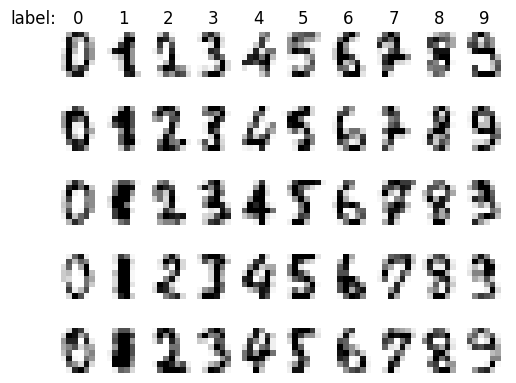

In [4]:
plot_dataset(X, y, rows=5)

### Preprocessing
To make the data readable by the machine learning model, we need to perform a couple of preprocessing step, starting with dimensionality reduction.

#### Dimensionality Reduction
State of the art quantum computers can perform computations on a limited set of qubits. Also simulating them on classical hardware is only possible for a few such qubits. Handling our $64$ input features (one for every pixel) would result in either a very wide (not possible yet) or very deep (very noisy) quantum circuit for our feature map. Therefore we perform dimensionality reduction in form of T-SNE. This leaves us with two features for every input image.

In [5]:
X_tsne = TSNE(n_components=2, learning_rate="auto", init="random", perplexity=40).fit_transform(X)

#### Min Max Scaling
Next we continue to scale the data to be in the interval $\left[0.9, 0.9\right]$ for both dimensions. This improves performance of the machine learning model by not overly considering one of the features.

In [6]:
Scaler = MinMaxScaler((-0.9, 0.9))
Scaler.fit(X_tsne)
X_scaled = Scaler.transform(X_tsne)

We can now plot the data in the featurespace.

*Hint: Rerun the cell a couple of times to view different samples and their respective position in feature space.*

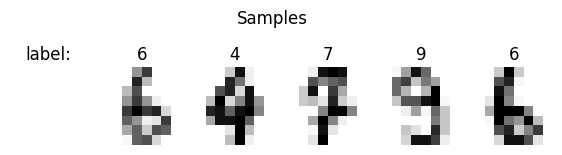

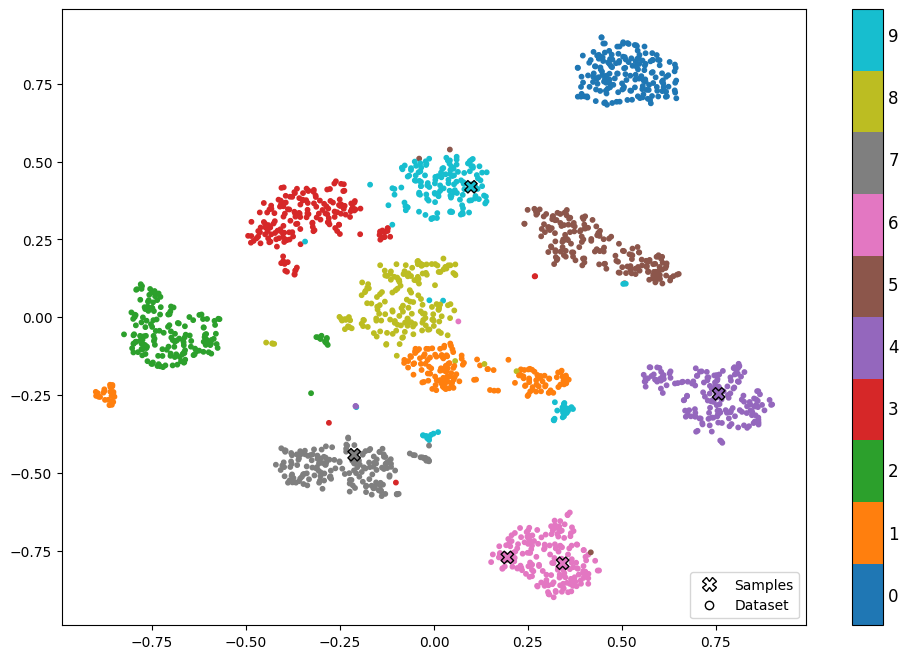

In [7]:
rows = np.random.choice(np.arange(1000, X.shape[0]), 5, replace=False)
plot_numbers(X[rows, :], y[rows], title="label:")

plot_data_in_feature_space(X_scaled, y, highlight_rows=rows)

We can clearly see the different clusters of numbers in the new featurespace. We also see the location of our samples marked by 🞭 with their true label.

### Split Datasets

Lastly we select $n$ samples and split the dataset into one for training and one for testing.

In [8]:
n_samples = 1000

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled[:n_samples, :],
    y[:n_samples],
    test_size=0.33,
    random_state=42,
)

## Classification
We are now set to continue learning a model to classify the numbers.

#### Quantum Kernel Methods
Kernel methods are a set of powerful techniques used in machine learning for solving various problems, such as classification, regression, and clustering.

<center>
<img src="images/feature_map.png" alt="feature map" width="800"/>

*Fig. 2: Example of a feature map.*
</center>


The core idea behind kernel methods is to transform the input data $x$ into a high-dimensional feature space, where it becomes easier to separate or classify the data. The figure above shows an example for such a transformation $\phi\left(x\right)$. It's not possible to separate the data on the left with a line but we can separate the data on the right with a hyperplane. We continue to calulate the similarity between two datapoints $x$ and $y$ in the high-dimensional space by evaluating the scalar product $\langle \phi\left(x\right), \phi\left(y\right) \rangle$. The classical kernel trick allows us to directly compute the similarity between the datapoints without explicitly calculating the feature maps.

#### Quantum Kernels
Quantum kernels leverage parameterized quantum circuits (PQC) to map an input $x$ to a quantum state $\ket{\phi\left(x\right)}$ in a potentially high dimensional quantum Hilbert space. In this case, the feature map (cf. Fig. 2) is the data encoding map. We obtain a quantum kernel by measuring the similarity between the wavefunctions created by encoding two different values $x$ and $y$ 
$$k\left(x, y\right) = \left\vert\left\langle\phi(x)\vert \phi(y)\right\rangle\right\vert^2\text{.}$$

Calculating quantum kernels by encoding the features separately has several drawbacks. For example, each element of the kernel matrix has to be calculated separately, such that the overall calculation of the kernel matrix scales quadraticially with the size of the dataset. In this demonstrator, we projected quantum kernels instead. They have some intriguing properties.

### Projected Quantum Kernel
With large effective dimensions (the dimension of the feature space), quantum kernels will see all data far from each other and thus have bad learning performance. Projected quantum kernels alleviate this problem by projecting the feature back to a classical space and computing the kernel there. This also comes with the advantage of needing to encode each input into quantum Hilbert space only once which leads to a linear scaling with the number of data points.


<center>
<img src="images/projected_quantum_kernel.png" alt="projected quantum kernel" width="600"/>

*Fig. 3: Visualization of a projected quantum kernel. Image taken from [1].*
</center>

In this notebook, we encode the classical data into a quantum computer using a  PQC with four qubits and three data-encoding layers. Each layer applies rotations $\mathrm{R}_\mathrm{X}$, using the product of a trainable parameter with the $\arccos$ of the input as the rotation angle and is followed by a circular entanglement layer using parameterized controlled $\mathrm{R}_\mathrm{Z}$ gates. The layers are enclosed in between two layers of parameterized $\mathrm{R}_\mathrm{Y}$ rotations. We will use a parameter vector $x$ for the input data and a parameter vector $p$ for the trainable parameters.

Let's plot the resulting quantum circuit.

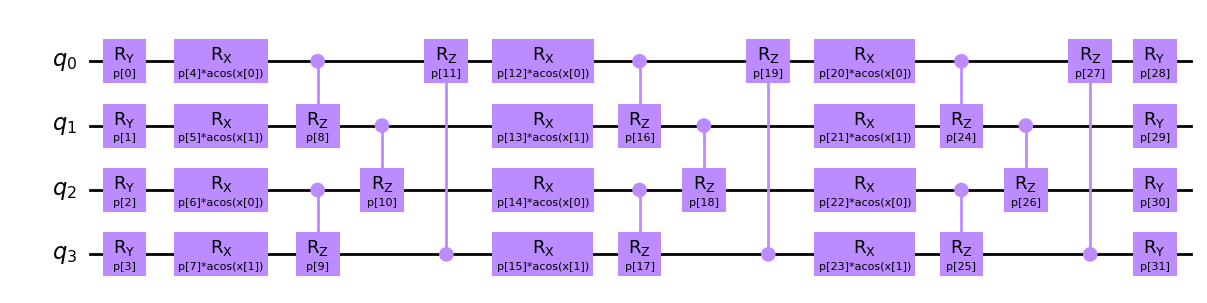

In [9]:
feature_map = ChebPQC(num_qubits=4, num_features=2, num_layers=3)
feature_map.draw(output="mpl")

Note that since we only have a two-dimensional input $x$ but twelve encoding quantum gates, we will repeat the data for the gates in ascending layer and qubit order. The resulting model is thus called a data-reuploading model. Each gate has their own trainable parameter, leaving us with $32$ trainable parameters.

Let's use the PQC to create a kernel matrix. We will measure in $\mathrm{X}$, $\mathrm{Y}$ and $\mathrm{Z}$ direction on each qubit. This maps the embedded data back to a classical feature space of dimension $12$. Furthermore, the projected quantum kernel will use a Gaussian outer kernel, i.e. it will compute each matrix element as
$$ K_{ij} = \exp\left(-\gamma\left\lvert\mathrm{PQC}\left(\theta,x_i\right)-\mathrm{PQC}\left(\theta,x_j\right)\right\rvert_2^2\right)$$
where $\left\lvert\cdot\right\rvert_2$ corresponds to the $L_2$-norm for vectors. $\gamma$ is a parameter which we will fix to $0.5$. Note again, that we only need to compute each feature map $x_i\mapsto\mathrm{PQC}\left(\theta,x_i\right)$ once.

In [10]:
kernel = ProjectedQuantumKernel(
    feature_map=feature_map,
    executor=Executor("statevector_simulator"),
    measurement="XYZ",
    outer_kernel="gaussian",
    initial_parameters=np.random.rand(feature_map.num_parameters),
    gamma=0.5,
)

### Support Vector Machine
We are now ready to train a Support Vector Machine (SVM) with our quantum kernel.

A Support Vector Machine (SVM) is a machine learning algorithm used for classification or regression tasks. It works by finding a hyperplane that separates data points into different categories. The hyperplane is chosen so that it maximizes the distance between the closest data points from each category. These closest points are called support vectors, and they help define the decision boundary. Once the decision boundary is established, new data points can be classified based on which side of the boundary they fall on.

Let's now fit the SVM to our training data.

In [11]:
qsvc = QSVC(quantum_kernel=kernel)
qsvc.fit(X_train, y_train)

QSVC(C=1.0, break_ties=False, cache_size=200, class_weight=None,
     decision_function_shape='ovr', max_iter=-1, probability=False,
     quantum_kernel=<squlearn.kernel.matrix.projected_quantum_kernel.ProjectedQuantumKernel object at 0x0000029A603CADF0>,
     random_state=None, shrinking=True, tol=0.001, verbose=False)

We check its performance on the training and test data.

In [12]:
predictions = qsvc.predict(X_train)
print(f"Train accuracy score {accuracy_score(y_train, predictions)}")
predictions = qsvc.predict(X_test)
print(f"Test accuracy score {accuracy_score(y_test, predictions)}")

Train accuracy score 0.9462686567164179
Test accuracy score 0.9696969696969697


The accuracy score describes the share of correctly classified data points. In multiclass classification it is calculated as $$\text{Accuracy} = \frac{\text{correct classifications}}{\text{total classifications}}\text{.}$$

We can go back to the previous plot we created and add more information to it. Specifically, we will highlight which data points were used for training and testing, and we will also show the true labels for each data point. To help us understand how the SVM makes its decisions, we will add a line on the plot called the decision boundary. Additionally, the colors of the background in the plot will indicate the region where the SVM assigns a specific label to each data point.

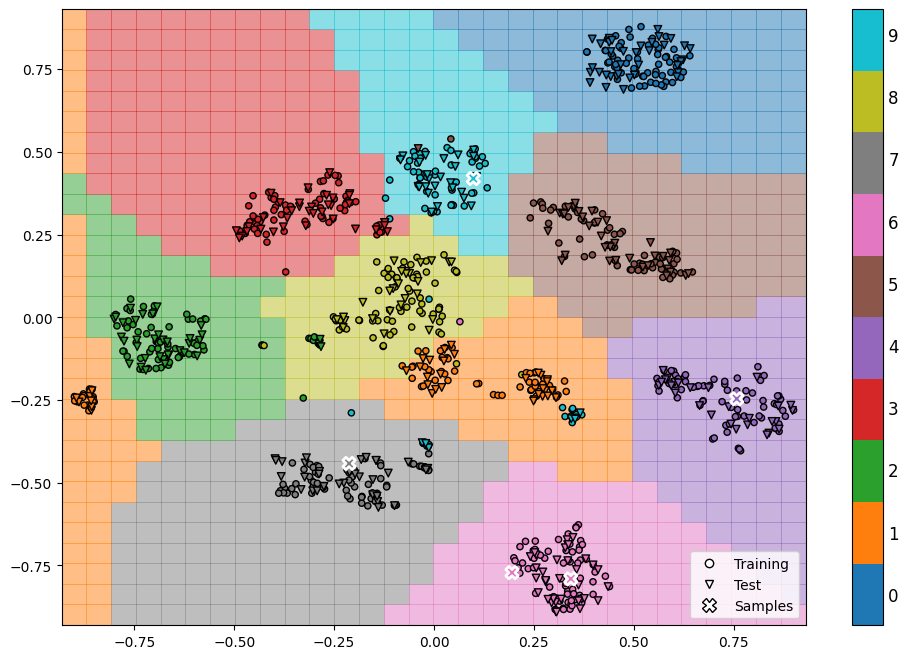

In [13]:
plot_results(
    clf=qsvc,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    X_highlight=X_scaled[rows],
    y_highlight=y[rows],
    X_range=[(-0.9, 0.9), (-0.9, 0.9)],
    resolution=30,
)

Finally let's see how our model predicts the data samples we chose in the beginning.

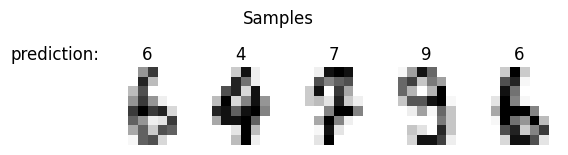

In [14]:
y_pred = qsvc.predict(X_scaled[rows, :])

plot_numbers(X[rows, :], y_pred, title="prediction:")

## Literature
[1] Huang, HY., Broughton, M., Mohseni, M. *et al.* Power of data in quantum machine learning. *Nat Commun* **12**, 2631 (2021). https://doi.org/10.1038/s41467-021-22539-9